In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from flask import Flask, request
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [10]:
# Set paths manually
MONKEYPOX_DIR = r"D:\MINI PROJECT SEM 3\archive\archive\Fold1\Fold1\Fold1\Train\Monkeypox"  # Folder with Monkeypox images
OTHERS_DIR = r"D:\MINI PROJECT SEM 3\archive\archive\Fold1\Fold1\Fold1\Train\Others"        # Folder with Other images
MODEL_SAVE_PATH = "monkeypox_mobilenetv2_model.h5"
UPLOAD_FOLDER = "uploads"

os.makedirs(UPLOAD_FOLDER, exist_ok=True)

In [11]:
# Flask app
app = Flask(__name__)

# Preprocess Function
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Resize and normalize image for prediction.
    """
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0) / 255.0  # Normalize
    return image_array

In [12]:
def load_dataset(monkeypox_dir, others_dir):
    """
    Load dataset with images and labels.
    """
    data, labels = [], []
    for label, folder in enumerate([monkeypox_dir, others_dir]):
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            try:
                image = load_img(filepath, target_size=(224, 224))
                image_array = img_to_array(image)
                data.append(image_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")
    data = np.array(data) / 255.0  # Normalize
    labels = np.array(labels)
    return data, labels

In [13]:
def create_model():
    """
    Build MobileNetV2-based CNN model.
    """
    base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    output = Dense(2, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [14]:
def train_model():
    """
    Train the model using the dataset and return data splits for evaluation.
    """
    data, labels = load_dataset(MONKEYPOX_DIR, OTHERS_DIR)
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    model = create_model()
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)
    model.save(MODEL_SAVE_PATH)
    print(f"Model saved at {MODEL_SAVE_PATH}.")
    return model, x_test, y_test

In [15]:
if os.path.exists(MODEL_SAVE_PATH):
    model = load_model(MODEL_SAVE_PATH)
    _, x_test, y_test = train_model()  # For evaluation purposes
else:
    model, x_test, y_test = train_model()

Epoch 1/10
54/54 [==============================] - 96s 2s/step - loss: 0.5216 - accuracy: 0.7443 - val_loss: 0.3205 - val_accuracy: 0.8625
Epoch 2/10
54/54 [==============================] - 83s 2s/step - loss: 0.3099 - accuracy: 0.8616 - val_loss: 0.2681 - val_accuracy: 0.8858
Epoch 3/10
54/54 [==============================] - 83s 2s/step - loss: 0.2403 - accuracy: 0.8920 - val_loss: 0.2237 - val_accuracy: 0.8974
Epoch 4/10
54/54 [==============================] - 93s 2s/step - loss: 0.1818 - accuracy: 0.9189 - val_loss: 0.2023 - val_accuracy: 0.9184
Epoch 5/10
54/54 [==============================] - 96s 2s/step - loss: 0.1559 - accuracy: 0.9329 - val_loss: 0.1691 - val_accuracy: 0.9324
Epoch 6/10
54/54 [==============================] - 87s 2s/step - loss: 0.1474 - accuracy: 0.9335 - val_loss: 0.2079 - val_accuracy: 0.9091
Epoch 7/10
54/54 [==============================] - 96s 2s/step - loss: 0.1159 - accuracy: 0.9568 - val_loss: 0.1752 - val_accuracy: 0.9301
Epoch 8/10
54/54 [==

c:\Users\Devank\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model saved at monkeypox_mobilenetv2_model.h5.


Accuracy: 0.93


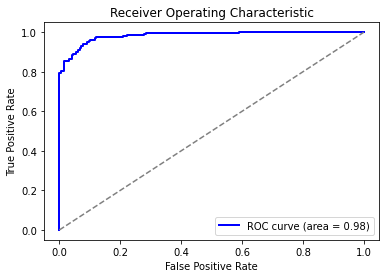

In [16]:
def evaluate_model(model, x_test, y_test):
    """
    Plot ROC Curve and compute accuracy.
    """
    predictions = model.predict(x_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Accuracy
    acc = accuracy_score(y_test, predicted_classes)
    print(f"Accuracy: {acc:.2f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, predictions[:, 1])  # Get probability scores for positive class
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

evaluate_model(model, x_test, y_test)

In [17]:
# Flask Routes
@app.route("/", methods=["GET", "POST"])
def index():
    """
    Handles image upload and prediction.
    """
    if request.method == "POST":
        if 'file' not in request.files:
            return "No file uploaded."
        file = request.files["file"]
        file_path = os.path.join("uploads", file.filename)
        file.save(file_path)

        # Preprocess and predict
        image = preprocess_image(file_path)
        prediction = model.predict(image)
        label = "Monkeypox" if np.argmax(prediction) == 1 else "Others"

        return f"""
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>Prediction Result</title>
            <style>
                body {{
                    font-family: "Helvetica Neue", Arial, sans-serif;
                    background-color: #f5f5dc;
                    color: #5a5a5a;
                    text-align: center;
                    margin: 0;
                    padding: 0;
                }}
                h1 {{
                    margin-top: 40px;
                    font-size: 2rem;
                    color: #8b7765;
                }}
                p {{
                    font-size: 1rem;
                    color: #444;
                }}
                img {{
                    margin: 20px 0;
                    border-radius: 8px;
                    box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
                }}
                a {{
                    display: inline-block;
                    margin-top: 20px;
                    color: #8b7765;
                    text-decoration: none;
                    font-size: 0.9rem;
                }}
                a:hover {{
                    text-decoration: underline;
                }}
            </style>
        </head>
        <body>
            <h1>Prediction Result</h1>
            <p><b>Result:</b> {label}</p>
            <img src="/{file_path}" style="width: 300px;" alt="Uploaded Image" />
            <a href="/">Analyze Another Image</a>
        </body>
        </html>
        """
    # Return the HTML for the main upload page
    return """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Monkeypox Detection</title>
        <style>
            body {
                font-family: "Helvetica Neue", Arial, sans-serif;
                background-color: #f5f5dc;
                color: #5a5a5a;
                text-align: center;
                margin: 0;
                padding: 0;
            }
            h1 {
                margin-top: 40px;
                font-size: 2rem;
                color: #8b7765;
            }
            form {
                margin: 50px auto;
                background-color: #fffaf0;
                padding: 20px;
                border-radius: 8px;
                box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
                width: 90%;
                max-width: 350px;
            }
            input[type="file"] {
                padding: 8px;
                margin: 15px 0;
                font-size: 0.9rem;
                border: 1px solid #dcdcdc;
                border-radius: 4px;
                width: 100%;
            }
            button {
                background-color: #deb887;
                color: #ffffff;
                padding: 10px 15px;
                font-size: 1rem;
                border: none;
                border-radius: 5px;
                cursor: pointer;
                transition: background-color 0.2s ease;
            }
            button:hover {
                background-color: #c2a676;
            }
            a {
                display: inline-block;
                margin-top: 20px;
                color: #8b7765;
                text-decoration: none;
                font-size: 0.9rem;
            }
            a:hover {
                text-decoration: underline;
            }
        </style>
    </head>
    <body>
        <h1>Monkeypox Detection</h1>
        <form action="/" method="POST" enctype="multipart/form-data">
            <input type="file" name="file" accept="image/*" required><br>
            <button type="submit">Upload and Analyze</button>
        </form>
        <a href="/">Analyze Another Image</a>
    </body>
    </html>
    """

In [ ]:
if __name__ == "__main__":
    # Ensure the 'uploads' directory exists
    os.makedirs("uploads", exist_ok=True)

    # Run without debug mode to suppress warnings
    print("Running on http://127.0.0.1:5000")
    app.run(port=5000)

Running on http://127.0.0.1:5000
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [26/Dec/2024 23:56:10] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2024 23:56:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2024 23:56:17] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [26/Dec/2024 23:56:45] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2024 23:56:46] "GET /uploads/M19_01.jpg HTTP/1.1" 404 -
127.0.0.1 - - [26/Dec/2024 23:56:50] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2024 23:57:18] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2024 23:57:19] "GET /uploads/M38_01.jpg HTTP/1.1" 404 -
